# Music Genre Classification

In [2]:
import numpy as np             
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd             
import seaborn as sns          
import sklearn  
import pickle

В данной работе использовался GTZAN Dataset. 

Эксперты долгое время пытались понять звук и то, что отличает одну песню от другой.

## 1. Загрузка данных

GTZAN Dataset включает в себя:


- аудиофайлы формата WAV - Коллекция из 10 жанров по 100 аудиофайлов в каждом, все продолжительностью 30 секунд. 
- Исходные изображения — визуальное представление для каждого аудиофайла. Одним из способов классификации данных являются нейронные сети. Поскольку нейронные сети (например, CNN) обычно принимают какое-то представление изображения, аудиофайлы были преобразованы в спектрограммы Мела.
- 2 CSV-файла - содержат характеристики аудиофайлов. В одном файле для каждой песни (длительностью 30 секунд) вычислено среднее значение и дисперсия по множеству функций, которые можно извлечь из аудиофайла. Другой файл имеет ту же структуру, но песни были разделены на 3-секундные аудиофайлы (таким образом, объем данных увеличивается в 10 раз).

Загружаем CSV-файл с локального диска.

In [3]:
fnameDataAudio = 'E:/music/archive/Data/features_30_sec.csv'

dfDataAudio = pd.read_csv(fnameDataAudio)

Таблица содержит данные о 10 жанрах по 100 аудиофайлов продолжительностью в 30 секунд.

В датасет входят такие жанры как:

1. Блюз
2. Классичекая
3. Кантри
4. Диско
5. Хип хоп
6. Джаз
7. Металл
8. Поп
9. Рок
10. Регги 

Вначале посмотрим на размеры таблицы: количество строк (каждая строка соответствует одной аудиозаписи) и количество столбцов (каждый столбец соответствует конкретному признаку):

In [3]:
dfDataAudio.shape

(1000, 60)

Отобразим первве пять строк таблицы:

In [4]:
dfDataAudio.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


Посмотрим, какие типы данных имеет таблица с помощью метода info().

In [5]:
dfDataAudio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

Столбцы (признаки) имеют имена:

- filename - имя аудиофайла
- length - длина аудиофайла
- chroma_stft - представляет сигнал в частотно-временной области путем вычисления дискретных преобразований Фурье (DFT) по коротким перекрывающимся окнам.
- zero_crossing - скорость пересечения нуля указывает, сколько раз сигнал пересекает горизонтальную ось
- spectral_centroid - Спектральные центроиды указывают, где расположен центр масс спектра.Он рассчитывается как средневзвешенное значение частот, присутствующих в сигнале, определенных с помощью преобразования Фурье, с их величинами в качестве весов.
- spectral_bandwidth - Спектральная полоса пропускания — это интересующий спектральный диапазон вокруг центроида, то есть отклонение от спектрального центроида.
- tempo - это скорость, с которой повторяется паттерн. Темп измеряется в ударах в минуту
- rolloff - Спектральный спад — это частота, ниже которой определенный процент от общей спектральной энергии
- harmony - гармонический звук — это то, что мы воспринимаем как тональный звук, то, что заставляет нас слышать мелодии и аккорды. Прототипом гармонического звука является акустическая реализация синусоиды, которая соответствует горизонтальной линии в представлении спектрограммы.
- perceptr - ударный звук — это то, что мы воспринимаем как столкновение, стук, хлопок или щелчок. Прототипом ударного звука является акустическая реализация импульса, которому соответствует вертикальная линия на изображении спектрограммы.

Можно увидеть, что признаки filename и label имеют номинальный (категориальный) тип, остальные признаки числовые, причем length имеет целочисленный тип.

Постановка задачи: предсказать жанр аудиофайла (задача классификации). 

# 2. Предварительная обработка данных

### Обработка категориальных значений

Столбцы filename и label имеют категориальные значения. Осуществим предобработку данных. Первый столбец filename, содержищий имена аудиофайлов, не будет участвовать в обучении модели. У столбца label заменим тип на специальный, предназначенный для хранения категориальных значений: 

In [5]:
dfDataAudio['label'] = dfDataAudio['label'].astype('category')
dfDataAudio['label'].dtype

CategoricalDtype(categories=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
                  'metal', 'pop', 'reggae', 'rock'],
                 ordered=False)

Выведем информация о числовых признаках:

In [7]:
dfDataAudio.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,...,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,...,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,...,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,...,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,...,1.212809,52.325077,-4.065605,54.717674,0.669643,54.804890,-2.393862,57.423059,-1.166289,59.186117
75%,661794.000000,0.435942,0.091256,0.175682,0.003577,2691.294667,6.121479e+05,2578.469836,182371.576801,5533.810460,...,4.359662,71.691755,-0.838737,75.040838,3.119212,75.385832,0.150573,78.626444,1.312615,85.375374
max,675808.000000,0.663685,0.108111,0.397973,0.027679,4435.243901,3.036843e+06,3509.646417,694784.811549,8677.672688,...,13.457150,392.932373,11.482946,406.058868,15.388390,332.905426,14.694924,393.161987,15.369627,506.065155


Информация о категориальных признаках:

In [8]:
dfDataAudio.describe(include=['category'])

,label
count,1000
unique,10
top,rock
freq,100


### Обработка пропущенных значений

Убедимся, что пропущенных значений нет в данном датасете.

In [9]:
dfDataAudio.isnull().sum()

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

### Обработка нерелеватных признаков

Все признаки были взяты из предварительно построенных спектограмм аудиофайлов. 

Стоит убрать из рассмотрения несколько столбецов: filename, содержащий имена файлов из таблицы, и length, содержащий в себе длину аудифайла, т.к. длина всех композиций одинакова.

In [4]:
dfDataAudio = dfDataAudio.drop(['filename', 'length'], axis=1)
dfDataAudio.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


## 3. Разделение на тренировочную и тестовую выборки

Из таблицы последний столбец преобразуем в y, остальные столбцы в X.

In [5]:
data = dfDataAudio.iloc[:, :-1]
data

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,1.222421e+06,...,1.789867,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665
996,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,1.046621e+06,...,3.739020,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624
997,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,8.042154e+05,...,1.838090,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515
998,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,1.332712e+06,...,-2.812176,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088


In [6]:
labels = dfDataAudio.iloc[:, -1]
labels
#labels.to_frame()

0      blues
1      blues
2      blues
3      blues
4      blues
       ...  
995     rock
996     rock
997     rock
998     rock
999     rock
Name: label, Length: 1000, dtype: object

Сразу промасштабируем данные.

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
encoder = LabelEncoder()
scaler = StandardScaler()

In [8]:
x = np.array(data, dtype = float)
x = scaler.fit_transform(data)
y = encoder.fit_transform(labels)
x.shape, y.shape

((1000, 57), (1000,))

Не забываем о stratify, чтобы данные по классам размешались равномерно.

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42, stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((750, 57), (250, 57), (750,), (250,))

## 4. Визуализация данных из обучающей выборки

Проверим, что данные разделились равномерно:

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

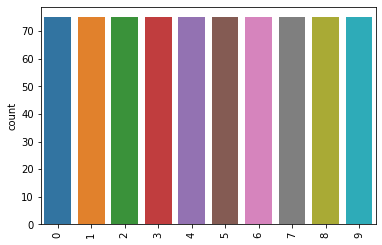

In [13]:
#sns.countplot(x=dfDataAudio.label)
sns.countplot(x=y_train)
plt.xticks(rotation=90)

Построим диаграммы рассеивания. 

Т.к. количественных признаков много, то построение диаграммы рассеивания будет выглядеть так:

In [9]:
dfXtrain = pd.DataFrame(x_train)

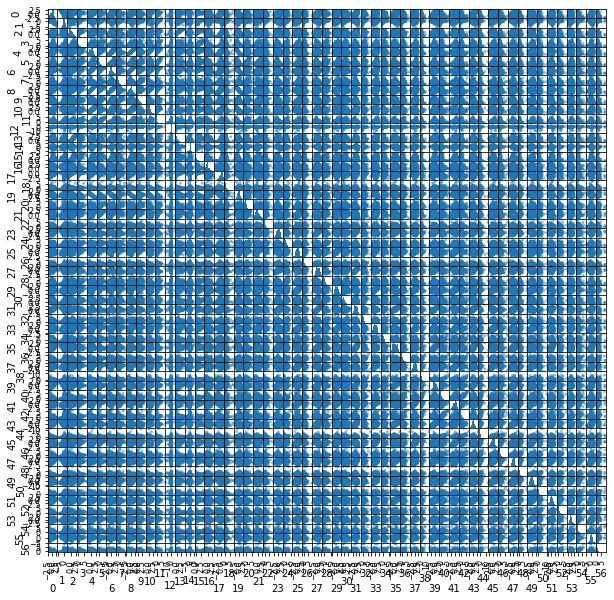

In [10]:
from pandas.plotting import scatter_matrix
scatter_matrix(dfXtrain, figsize = (10, 10))
pass

Поэтому диаграмму рассеивания сделаем по частям

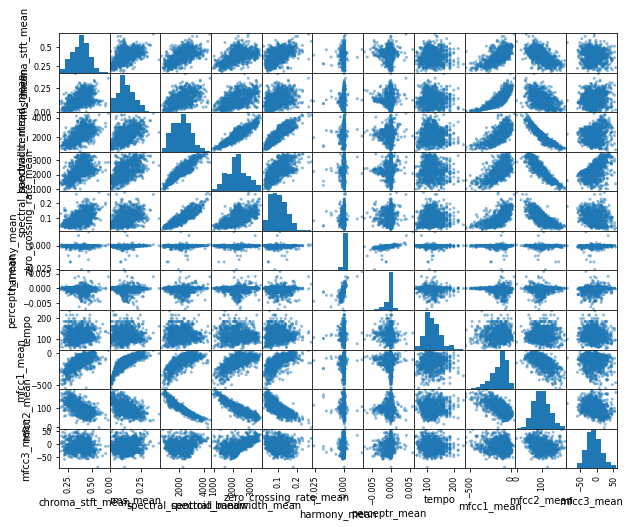

In [8]:
pd.plotting.scatter_matrix(dfDataAudio[['chroma_stft_mean', 'rms_mean', 'spectral_centroid_mean', 'spectral_bandwidth_mean', 'zero_crossing_rate_mean', 'harmony_mean', 'perceptr_mean', 'tempo', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean']], figsize = (10, 8))
pass

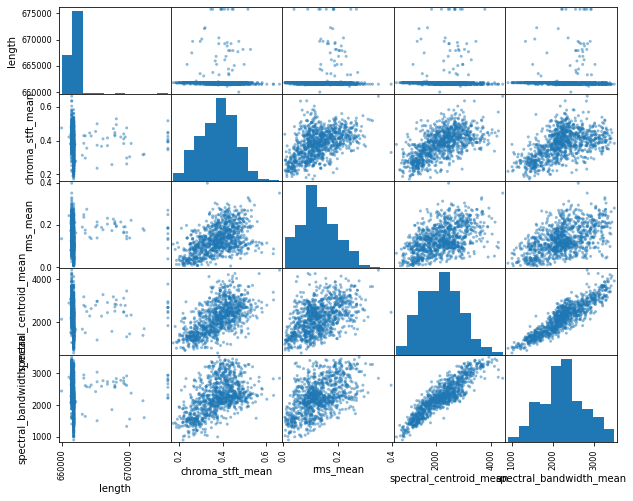

In [4]:
pd.plotting.scatter_matrix(dfDataAudio[['chroma_stft_mean', 'rms_mean', 'spectral_centroid_mean', 'spectral_bandwidth_mean', 'rolloff_mean', ]], figsize = (10, 8))
pass

Вычислим матрицу корреляции для количественных признаков:

In [34]:
corr_mat = data.corr()
corr_mat

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
chroma_stft_mean,1.000000,-0.461729,0.499926,0.261544,0.615728,0.285926,0.517710,0.041088,0.598122,0.117139,...,0.332359,-0.452955,-0.163474,-0.456298,0.269935,-0.478452,-0.089509,-0.501768,0.281965,-0.548577
chroma_stft_var,-0.461729,1.000000,-0.078777,0.290138,-0.246441,0.305819,-0.036896,0.346907,-0.168721,0.383134,...,-0.311178,0.361752,0.205117,0.389468,-0.239597,0.378200,0.184323,0.365291,-0.231715,0.333581
rms_mean,0.499926,-0.078777,1.000000,0.607399,0.510154,0.324077,0.530017,0.099830,0.537902,0.200083,...,0.083936,-0.160347,-0.029562,-0.163490,0.118239,-0.164834,0.031297,-0.207680,0.124413,-0.252434
rms_var,0.261544,0.290138,0.607399,1.000000,0.347831,0.583353,0.402333,0.320793,0.368570,0.417880,...,-0.093893,0.091863,0.168169,0.100234,-0.002585,0.058050,0.186953,0.049879,0.029364,0.012087
spectral_centroid_mean,0.615728,-0.246441,0.510154,0.347831,1.000000,0.520548,0.904435,0.011256,0.979637,0.198031,...,0.153741,-0.180200,0.027473,-0.158666,0.228275,-0.136272,0.027918,-0.146316,0.269601,-0.205531
spectral_centroid_var,0.285926,0.305819,0.324077,0.583353,0.520548,1.000000,0.622834,0.636494,0.545128,0.815550,...,-0.186864,0.072319,0.175573,0.094155,-0.063059,0.059431,0.188945,0.046847,-0.021837,0.008115
spectral_bandwidth_mean,0.517710,-0.036896,0.530017,0.402333,0.904435,0.622834,1.000000,0.220159,0.956189,0.438581,...,0.027206,-0.146152,0.105010,-0.122739,0.114873,-0.102737,0.098217,-0.121584,0.187786,-0.193574
spectral_bandwidth_var,0.041088,0.346907,0.099830,0.320793,0.011256,0.636494,0.220159,1.000000,0.053632,0.884877,...,-0.267098,0.104727,0.128638,0.108537,-0.178183,0.074145,0.124554,0.028696,-0.157001,0.026121
rolloff_mean,0.598122,-0.168721,0.537902,0.368570,0.979637,0.545128,0.956189,0.053632,1.000000,0.261685,...,0.132443,-0.180777,0.039693,-0.157343,0.205222,-0.131517,0.048248,-0.144641,0.256570,-0.215384
rolloff_var,0.117139,0.383134,0.200083,0.417880,0.198031,0.815550,0.438581,0.884877,0.261685,1.000000,...,-0.269606,0.101319,0.126617,0.107129,-0.163651,0.077524,0.131258,0.045181,-0.144971,0.019691


Вычислим тепловую карту.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5]),
 <a list of 28 Text major ticklabel objects>)

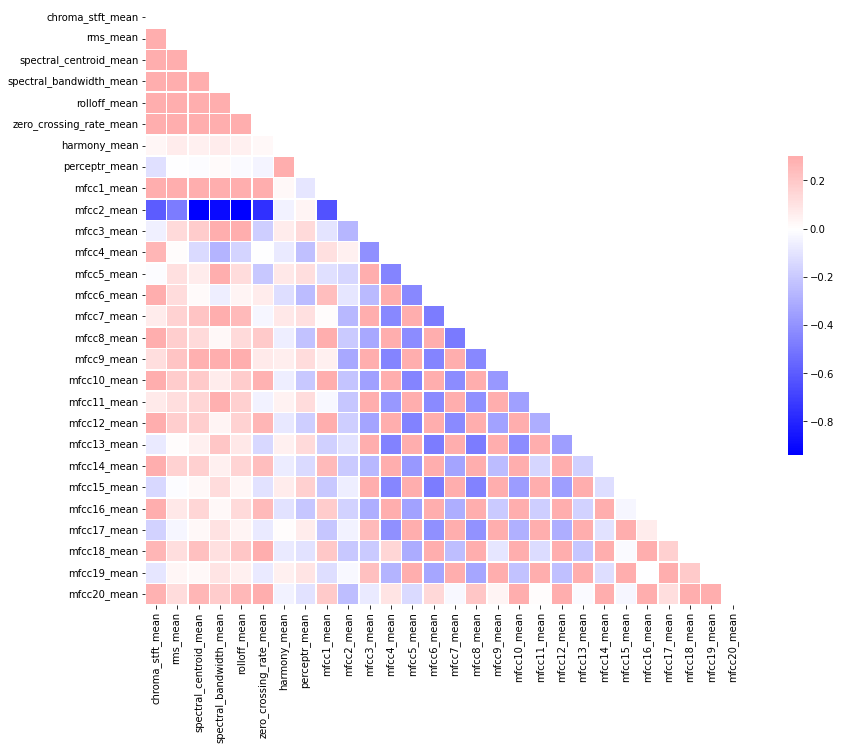

In [3]:
spike = [col for col in dfDataAudio.columns if 'mean' in col]
corr = dfDataAudio[spike].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(16, 11))

sns.heatmap(corr, mask=mask, cmap="bwr", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

Text(0, 0.5, 'BPM')

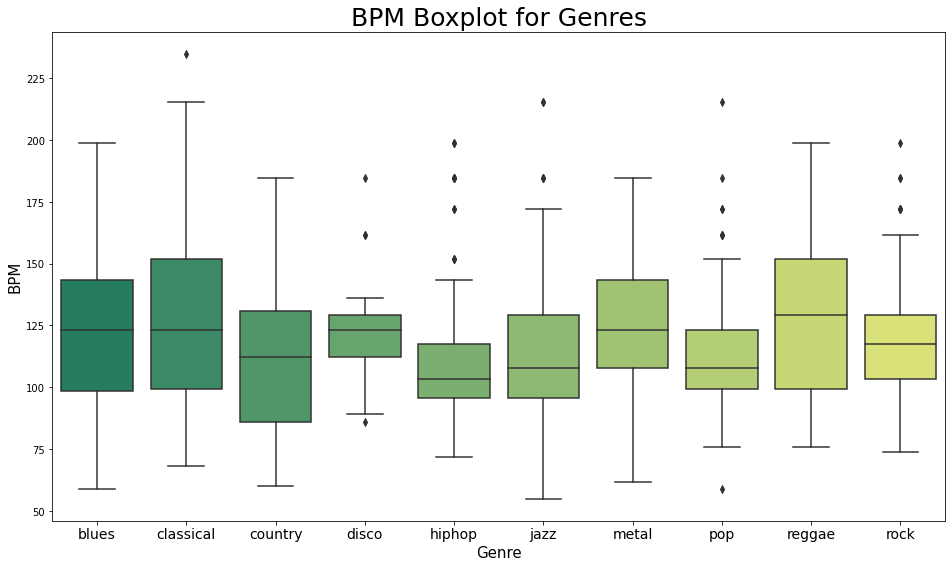

In [6]:
x = dfDataAudio[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9))
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'summer')

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10)
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

In [27]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [32]:
df = dfDataAudio.iloc[0:, 1:]
y = dfDataAudio['label']
X = df.loc[:, df.columns != 'label']

cols = X.columns
scaler = preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

pca = PCA(n_components=2)
scaled_df = pca.fit_transform(X)
df_p = pd.DataFrame(data = scaled_df, columns = ['pca1', 'pca2'])

fdf = pd.concat([df_p, y], axis = 1)

pca.explained_variance_ratio_


array([0.2523914 , 0.20972602])

Text(0, 0.5, 'Principal Component 2')

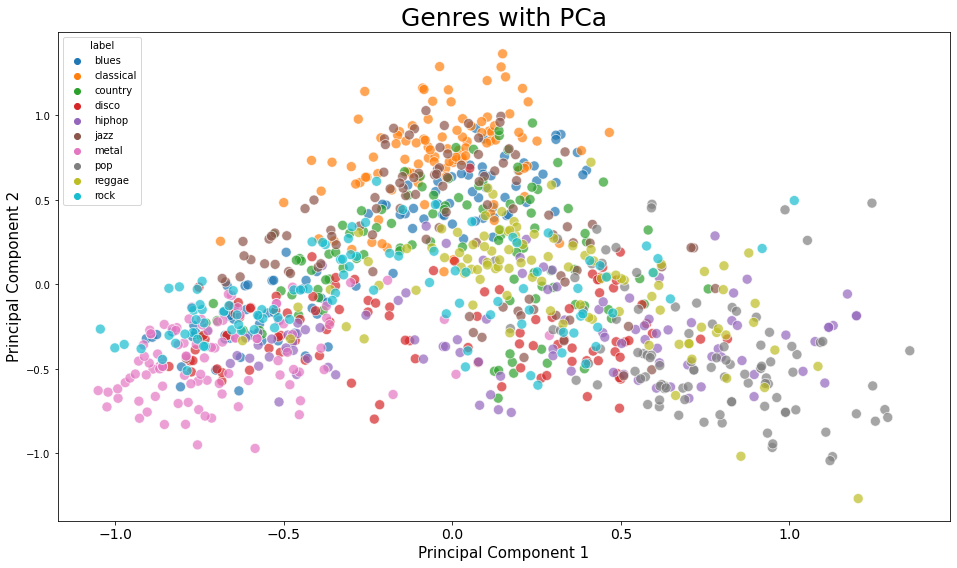

In [33]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pca1", y = "pca2", data = fdf, hue = "label", alpha = 0.7,
               s = 100)

plt.title('Genres with PCa', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10)
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)

## 5. Обучение моделей

### Метод k-ближайших соседей (K-Nearest Neighbors)

#### Обучение модели

In [35]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train, y_train)
knn_prediction = knn_model.predict(x_train)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

Поскольку это многоклассовая классификация, по одной метрике accuracy сравнивать модели нецелесообразно, поэтому будем вычислять еще одну метрику f1

In [38]:
print('accuracy_train = ', accuracy_score(knn_prediction, y_train))
print('f1_train = ', f1_score(knn_prediction, y_train, average='weighted'))

accuracy_train =  0.808
f1_train =  0.8075495995928977


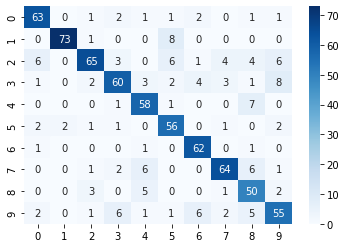

In [132]:
ax = sns.heatmap(confusion_matrix(knn_prediction, y_train), annot=True, cmap='Blues')
plt.show()

#### Тестирование модели

accuracy_test =  0.676
f1_test =  0.6774011544011543


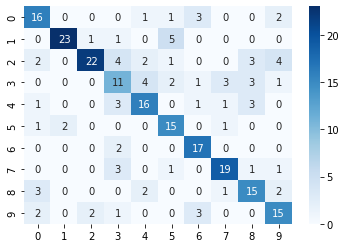

In [39]:
knn_prediction = knn_model.predict(x_test)
print('accuracy_test = ', accuracy_score(knn_prediction, y_test))
print('f1_test = ', f1_score(knn_prediction, y_test, average='weighted'))
ax = sns.heatmap(confusion_matrix(knn_prediction, y_test), annot=True, cmap='Blues')
plt.show()

In [58]:
print(classification_report(knn_prediction, y_test))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67        23
           1       0.92      0.77      0.84        30
           2       0.88      0.58      0.70        38
           3       0.44      0.44      0.44        25
           4       0.64      0.64      0.64        25
           5       0.60      0.79      0.68        19
           6       0.68      0.89      0.77        19
           7       0.76      0.76      0.76        25
           8       0.60      0.65      0.63        23
           9       0.60      0.65      0.63        23

    accuracy                           0.68       250
   macro avg       0.68      0.69      0.67       250
weighted avg       0.69      0.68      0.68       250



Видим, что модель при K=5 получает не самые лучшие результаты. Попробуем поизменять параметры для нахождения наилучших значений точности.

Экспериментальным путем при k от 1 до 45 при k = 4 и 11 получаем наибольшую (не считая k=5) accuracy = 0.708. Только при k = 4 и f1 =  0.7046821519644964, а при k = 11 получаем f1 =  0.714577170240174

accuracy_train =  0.7293333333333333
f1_train =  0.7301402870092427
accuracy_test =  0.708
f1_test =  0.714577170240174


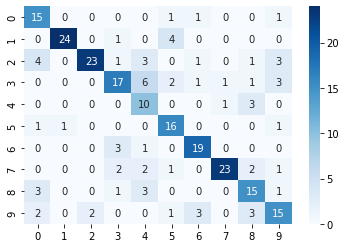

              precision    recall  f1-score   support

           0       0.60      0.83      0.70        18
           1       0.96      0.83      0.89        29
           2       0.92      0.64      0.75        36
           3       0.68      0.55      0.61        31
           4       0.40      0.71      0.51        14
           5       0.64      0.84      0.73        19
           6       0.76      0.83      0.79        23
           7       0.92      0.74      0.82        31
           8       0.60      0.65      0.63        23
           9       0.60      0.58      0.59        26

    accuracy                           0.71       250
   macro avg       0.71      0.72      0.70       250
weighted avg       0.74      0.71      0.71       250



In [133]:
knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(x_train, y_train)
knn_prediction = knn_model.predict(x_train)
print('accuracy_train = ', accuracy_score(knn_prediction, y_train))
print('f1_train = ', f1_score(knn_prediction, y_train, average='weighted'))

knn_prediction = knn_model.predict(x_test)

print('accuracy_test = ', accuracy_score(knn_prediction, y_test))
print('f1_test = ', f1_score(knn_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(knn_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(knn_prediction, y_test))

Лучшее значение метрик получаем при k = 5: accuracy =  0.808, f1 =  0.8075495995928977

### Метод опорных векторов (Support Vector Machines)

#### Обучение модели

In [40]:
from sklearn.svm import SVC
svc_model = SVC(kernel='rbf')
svc_model.fit(x_train, y_train)

SVC()

In [41]:
svc_prediction_train = svc_model.predict(x_train)
print('accuracy_train = ', accuracy_score(svc_prediction_train, y_train))
print('f1_train = ', f1_score(svc_prediction_train, y_train, average='weighted'))

accuracy_train =  0.888
f1_train =  0.8878815891286149


#### Тестирование модели

accuracy_test =  0.736
f1_test =  0.7368163490290761


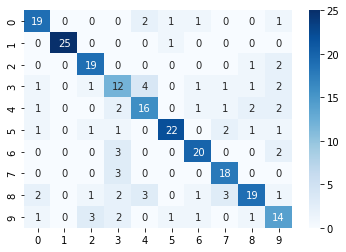

              precision    recall  f1-score   support

           0       0.76      0.79      0.78        24
           1       1.00      0.96      0.98        26
           2       0.76      0.86      0.81        22
           3       0.48      0.52      0.50        23
           4       0.64      0.64      0.64        25
           5       0.88      0.76      0.81        29
           6       0.80      0.80      0.80        25
           7       0.72      0.86      0.78        21
           8       0.76      0.59      0.67        32
           9       0.56      0.61      0.58        23

    accuracy                           0.74       250
   macro avg       0.74      0.74      0.74       250
weighted avg       0.74      0.74      0.74       250



In [42]:
svc_prediction = svc_model.predict(x_test)
print('accuracy_test = ', accuracy_score(svc_prediction, y_test))
print('f1_test = ', f1_score(svc_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(svc_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(svc_prediction, y_test))

Изменим параметр модели

accuracy_train =  0.6333333333333333
f1_train =  0.6369770324072873
accuracy_test =  0.572
f1_test =  0.5832460887052471


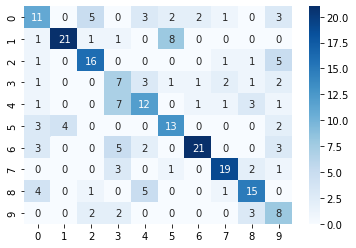

              precision    recall  f1-score   support

           0       0.44      0.41      0.42        27
           1       0.84      0.66      0.74        32
           2       0.64      0.67      0.65        24
           3       0.28      0.39      0.33        18
           4       0.48      0.46      0.47        26
           5       0.52      0.59      0.55        22
           6       0.84      0.62      0.71        34
           7       0.76      0.73      0.75        26
           8       0.60      0.58      0.59        26
           9       0.32      0.53      0.40        15

    accuracy                           0.57       250
   macro avg       0.57      0.56      0.56       250
weighted avg       0.61      0.57      0.58       250



In [43]:
svc_model = SVC(kernel='sigmoid')
svc_model.fit(x_train, y_train)
svc_prediction_train = svc_model.predict(x_train)
print('accuracy_train = ', accuracy_score(svc_prediction_train, y_train))
print('f1_train = ', f1_score(svc_prediction_train, y_train, average='weighted'))

svc_prediction = svc_model.predict(x_test)
print('accuracy_test = ', accuracy_score(svc_prediction, y_test))
print('f1_test = ', f1_score(svc_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(svc_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(svc_prediction, y_test))

accuracy_train =  0.7693333333333333
f1_train =  0.7530187694243755
accuracy_test =  0.608
f1_test =  0.5987376912625751


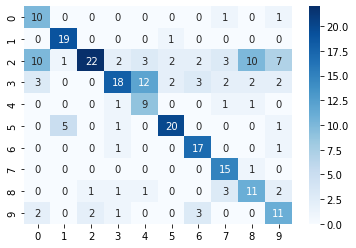

              precision    recall  f1-score   support

           0       0.40      0.83      0.54        12
           1       0.76      0.95      0.84        20
           2       0.88      0.35      0.51        62
           3       0.72      0.41      0.52        44
           4       0.36      0.75      0.49        12
           5       0.80      0.74      0.77        27
           6       0.68      0.89      0.77        19
           7       0.60      0.94      0.73        16
           8       0.44      0.58      0.50        19
           9       0.44      0.58      0.50        19

    accuracy                           0.61       250
   macro avg       0.61      0.70      0.62       250
weighted avg       0.69      0.61      0.60       250



In [44]:
svc_model = SVC(kernel='poly')
svc_model.fit(x_train, y_train)
svc_prediction_train = svc_model.predict(x_train)
print('accuracy_train = ', accuracy_score(svc_prediction_train, y_train))
print('f1_train = ', f1_score(svc_prediction_train, y_train, average='weighted'))

svc_prediction = svc_model.predict(x_test)
print('accuracy_test = ', accuracy_score(svc_prediction, y_test))
print('f1_test = ', f1_score(svc_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(svc_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(svc_prediction, y_test))

accuracy_train =  0.9786666666666667
f1_train =  0.978802008305795
accuracy_test =  0.672
f1_test =  0.6752282708306966


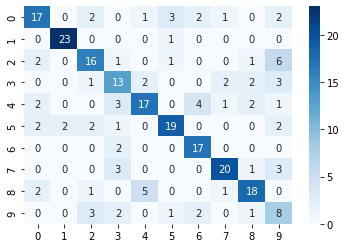

              precision    recall  f1-score   support

           0       0.68      0.61      0.64        28
           1       0.92      0.96      0.94        24
           2       0.64      0.59      0.62        27
           3       0.52      0.57      0.54        23
           4       0.68      0.57      0.62        30
           5       0.76      0.68      0.72        28
           6       0.68      0.89      0.77        19
           7       0.80      0.74      0.77        27
           8       0.72      0.67      0.69        27
           9       0.32      0.47      0.38        17

    accuracy                           0.67       250
   macro avg       0.67      0.67      0.67       250
weighted avg       0.69      0.67      0.68       250



In [45]:
svc_model = SVC(kernel='linear')
svc_model.fit(x_train, y_train)
svc_prediction_train = svc_model.predict(x_train)
print('accuracy_train = ', accuracy_score(svc_prediction_train, y_train))
print('f1_train = ', f1_score(svc_prediction_train, y_train, average='weighted'))

svc_prediction = svc_model.predict(x_test)
print('accuracy_test = ', accuracy_score(svc_prediction, y_test))
print('f1_test = ', f1_score(svc_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(svc_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(svc_prediction, y_test))

Видим, что наибольшие значения метрик на тестовой выборке получается у метода с ядром 'rbf'. 

###  Случайный лес (Random Forests)

#### Обучение модели

In [46]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train)

RandomForestClassifier()

In [47]:
rfc_prediction_train = rfc_model.predict(x_train)
print('accuracy_train = ', accuracy_score(rfc_prediction_train, y_train))
print('f1_train = ', f1_score(rfc_prediction_train, y_train, average='weighted'))

accuracy_train =  0.9986666666666667
f1_train =  0.9986667259285599


#### Тестирование модели

accuracy_test =  0.696
f1_test =  0.6996658605350072


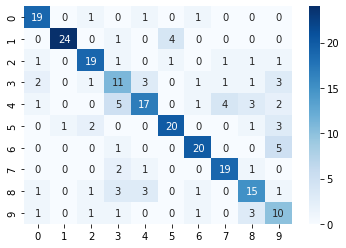

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        22
           1       0.96      0.83      0.89        29
           2       0.76      0.76      0.76        25
           3       0.44      0.48      0.46        23
           4       0.68      0.52      0.59        33
           5       0.80      0.74      0.77        27
           6       0.80      0.77      0.78        26
           7       0.76      0.83      0.79        23
           8       0.60      0.60      0.60        25
           9       0.40      0.59      0.48        17

    accuracy                           0.70       250
   macro avg       0.70      0.70      0.69       250
weighted avg       0.71      0.70      0.70       250



In [48]:
rfc_prediction = rfc_model.predict(x_test)
print('accuracy_test = ', accuracy_score(rfc_prediction, y_test))
print('f1_test = ', f1_score(rfc_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(rfc_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(rfc_prediction, y_test))

accuracy_train =  0.9986666666666667
f1_train =  0.9986667259285599
accuracy_test =  0.72
f1_test =  0.7199490291843234


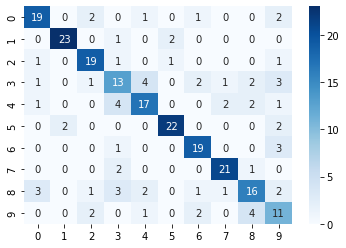

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        25
           1       0.92      0.88      0.90        26
           2       0.76      0.83      0.79        23
           3       0.52      0.48      0.50        27
           4       0.68      0.63      0.65        27
           5       0.88      0.85      0.86        26
           6       0.76      0.83      0.79        23
           7       0.84      0.88      0.86        24
           8       0.64      0.55      0.59        29
           9       0.44      0.55      0.49        20

    accuracy                           0.72       250
   macro avg       0.72      0.72      0.72       250
weighted avg       0.72      0.72      0.72       250



In [49]:
rfc_model = RandomForestClassifier(n_estimators=250, max_depth=25, criterion="entropy")
rfc_model.fit(x_train, y_train)
rfc_prediction_train = rfc_model.predict(x_train)
print('accuracy_train = ', accuracy_score(rfc_prediction_train, y_train))
print('f1_train = ', f1_score(rfc_prediction_train, y_train, average='weighted'))

rfc_prediction = rfc_model.predict(x_test)
print('accuracy_test = ', accuracy_score(rfc_prediction, y_test))
print('f1_test = ', f1_score(rfc_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(rfc_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(rfc_prediction, y_test))

accuracy_train =  0.9986666666666667
f1_train =  0.9986667259285599
accuracy_test =  0.724
f1_test =  0.7268691196051258


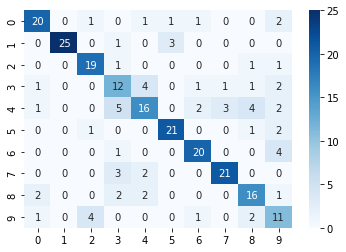

              precision    recall  f1-score   support

           0       0.80      0.77      0.78        26
           1       1.00      0.86      0.93        29
           2       0.76      0.86      0.81        22
           3       0.48      0.55      0.51        22
           4       0.64      0.48      0.55        33
           5       0.84      0.84      0.84        25
           6       0.80      0.80      0.80        25
           7       0.84      0.81      0.82        26
           8       0.64      0.70      0.67        23
           9       0.44      0.58      0.50        19

    accuracy                           0.72       250
   macro avg       0.72      0.72      0.72       250
weighted avg       0.74      0.72      0.73       250



In [50]:
rfc_model = RandomForestClassifier(n_estimators=250, max_depth=25)
rfc_model.fit(x_train, y_train)
rfc_prediction_train = rfc_model.predict(x_train)
print('accuracy_train = ', accuracy_score(rfc_prediction_train, y_train))
print('f1_train = ', f1_score(rfc_prediction_train, y_train, average='weighted'))

rfc_prediction = rfc_model.predict(x_test)
print('accuracy_test = ', accuracy_score(rfc_prediction, y_test))
print('f1_test = ', f1_score(rfc_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(rfc_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(rfc_prediction, y_test))

### Логистическая регрессия (Logistic Regression)

#### Обучение модели

In [51]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

#### Тестирование модели

In [53]:
logreg_prediction_train = logreg_model.predict(x_train)
print('accuracy_train = ', accuracy_score(logreg_prediction_train, y_train))
print('f1_train = ', f1_score(logreg_prediction_train, y_train, average='weighted'))

accuracy_train =  0.8986666666666666
f1_train =  0.8998270837524855


accuracy_test =  0.728
f1_test =  0.7270266170744448


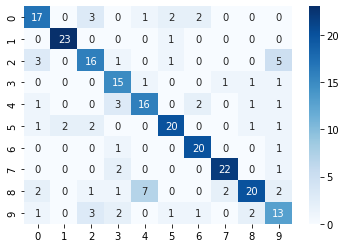

              precision    recall  f1-score   support

           0       0.68      0.68      0.68        25
           1       0.92      0.96      0.94        24
           2       0.64      0.62      0.63        26
           3       0.60      0.79      0.68        19
           4       0.64      0.67      0.65        24
           5       0.80      0.74      0.77        27
           6       0.80      0.91      0.85        22
           7       0.88      0.88      0.88        25
           8       0.80      0.57      0.67        35
           9       0.52      0.57      0.54        23

    accuracy                           0.73       250
   macro avg       0.73      0.74      0.73       250
weighted avg       0.73      0.73      0.73       250



In [54]:
logreg_prediction = logreg_model.predict(x_test)
print('accuracy_test = ', accuracy_score(logreg_prediction, y_test))
print('f1_test = ', f1_score(logreg_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(logreg_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(logreg_prediction, y_test))

c:\Users\PC\.conda\envs\deeplean\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy_train =  0.8826666666666667
f1_train =  0.8840023908844578
accuracy_test =  0.732
f1_test =  0.7312090472892984


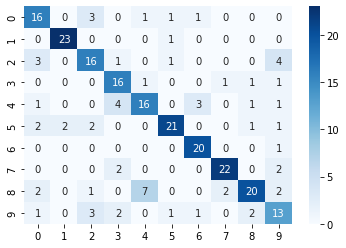

              precision    recall  f1-score   support

           0       0.64      0.73      0.68        22
           1       0.92      0.96      0.94        24
           2       0.64      0.64      0.64        25
           3       0.64      0.80      0.71        20
           4       0.64      0.62      0.63        26
           5       0.84      0.72      0.78        29
           6       0.80      0.95      0.87        21
           7       0.88      0.85      0.86        26
           8       0.80      0.59      0.68        34
           9       0.52      0.57      0.54        23

    accuracy                           0.73       250
   macro avg       0.73      0.74      0.73       250
weighted avg       0.74      0.73      0.73       250



In [55]:
logreg_model = LogisticRegression(solver='sag')
logreg_model.fit(x_train, y_train)
logreg_prediction_train = logreg_model.predict(x_train)
print('accuracy_train = ', accuracy_score(logreg_prediction_train, y_train))
print('f1_train = ', f1_score(logreg_prediction_train, y_train, average='weighted'))

logreg_prediction = logreg_model.predict(x_test)
print('accuracy_test = ', accuracy_score(logreg_prediction, y_test))
print('f1_test = ', f1_score(logreg_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(logreg_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(logreg_prediction, y_test))

c:\Users\PC\.conda\envs\deeplean\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy_train =  0.86
f1_train =  0.8611003044396125
accuracy_test =  0.732
f1_test =  0.7313713566574901


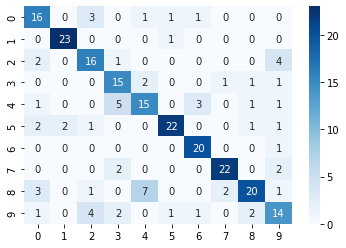

              precision    recall  f1-score   support

           0       0.64      0.73      0.68        22
           1       0.92      0.96      0.94        24
           2       0.64      0.70      0.67        23
           3       0.60      0.75      0.67        20
           4       0.60      0.58      0.59        26
           5       0.88      0.76      0.81        29
           6       0.80      0.95      0.87        21
           7       0.88      0.85      0.86        26
           8       0.80      0.59      0.68        34
           9       0.56      0.56      0.56        25

    accuracy                           0.73       250
   macro avg       0.73      0.74      0.73       250
weighted avg       0.74      0.73      0.73       250



In [56]:
logreg_model = LogisticRegression(solver='saga')
logreg_model.fit(x_train, y_train)
logreg_prediction_train = logreg_model.predict(x_train)
print('accuracy_train = ', accuracy_score(logreg_prediction_train, y_train))
print('f1_train = ', f1_score(logreg_prediction_train, y_train, average='weighted'))

logreg_prediction = logreg_model.predict(x_test)
print('accuracy_test = ', accuracy_score(logreg_prediction, y_test))
print('f1_test = ', f1_score(logreg_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(logreg_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(logreg_prediction, y_test))

Видим, что лучшие значения метрик получаем при solver='saga'. 

#### Итог

Метод k-ближайших соседей (K-Nearest Neighbors) при k = 5: accuracy =  0.808, f1 =  0.8075495995928977

Метод опорных векторов (Support Vector Machines) при kernel='rbf' accuracy =  0.736, f1 =  0.7368163490290761

Случайный лес (Random Forests) при n_estimators=250, max_depth=25, criterion="entropy" accuracy =  0.724, f1 =  0.728220222071988

Логистическая регрессия (Logistic Regression) при solver='saga' accuracy =  0.732, f1 =  0.7313713566574901, но solver='sag' по метрикам почтисовпадает.

## 6. Подбор гиперпараметеров

Для метода Случайный лес (Random Forests) произведем подбор оптимальных значений гиперпараметров.

Почему именно этот метод. Метод имеет небольшое число настраиваемых гиперпараметров, поддерживают работу с большими выборками, поддерживает работу с входными признаками разных (смешанных) типов.

Минус данной модели: деревья могут недообучаться и переобучаться, особенно, если неглубокие.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier()

Получим список возможных параметров выбранной модели:

In [10]:
rfc_model.get_params().keys() 

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

Видим, что параметров у модели много. Выберем несколько из вышеперечисленных: max_depth (максимальная глубина дерева), n_estimators (количество деревьев в лесу), criterion (функция для измерения качества разделения).

In [20]:
GSCV = GridSearchCV(rfc_model, {
		"n_estimators": list(range(100,1001,100)), 
 		"max_depth" : list(range(6, 42, 2)),
        "criterion" : ['gini', 'entropy']}, 
    cv = 3, # количество разбиений на кросс-валидацию
    scoring = 'neg_mean_absolute_error' # как мы будем оценивать модель (используем scoring нашей модели)
)

In [21]:
GSCV.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26,
                                       28, 30, 32, 34, 36, 38, 40],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]},
             scoring='neg_mean_absolute_error')

In [22]:
GSCV.best_score_, GSCV.best_params_

(-1.188, {'criterion': 'gini', 'max_depth': 26, 'n_estimators': 500})

accuracy =  0.728
f1 =  0.7317941477091505


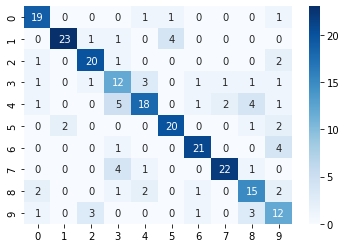

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        22
           1       0.92      0.79      0.85        29
           2       0.80      0.83      0.82        24
           3       0.48      0.57      0.52        21
           4       0.72      0.56      0.63        32
           5       0.80      0.80      0.80        25
           6       0.84      0.81      0.82        26
           7       0.88      0.79      0.83        28
           8       0.60      0.65      0.63        23
           9       0.48      0.60      0.53        20

    accuracy                           0.73       250
   macro avg       0.73      0.73      0.72       250
weighted avg       0.74      0.73      0.73       250



In [26]:
rfc_model = RandomForestClassifier(criterion = 'gini', max_depth = 26, n_estimators = 500)
rfc_model.fit(x_train, y_train)

rfc_prediction = rfc_model.predict(x_test)
print('accuracy = ', accuracy_score(rfc_prediction, y_test))
print('f1 = ', f1_score(rfc_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(rfc_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(rfc_prediction, y_test))

Но оценить GridSearchCV можно и по-другому scoring. Посмотрим, какие scoring есть.

In [29]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

Посмотрим теперь модель, если оценивать модель при f1_weighted.

In [15]:
GSCV = GridSearchCV(rfc_model, {
		"n_estimators": list(range(700,1001,100)), 
 		"max_depth" : list(range(20, 32, 2)),
        "criterion" : ['gini', 'entropy']}, 
    scoring = 'f1_weighted'
)

In [16]:
GSCV.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_depth=30, n_estimators=700),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 22, 24, 26, 28, 30],
                         'n_estimators': [700, 800, 900, 1000]},
             scoring='f1_weighted')

In [17]:
GSCV.best_score_, GSCV.best_params_

(0.707695263914766,
 {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 1000})

In [18]:
MSE_arr = -GSCV.cv_results_['mean_test_score']
std_arr = GSCV.cv_results_['std_test_score']

In [32]:
GSCV.best_score_, GSCV.best_params_

(0.7113209871885624,
 {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 700})

Построим график зависимости ошибок

In [24]:
k_arr = range(2* len([20, 22, 24, 26, 28, 30]) * len([700, 800, 900, 1000]))

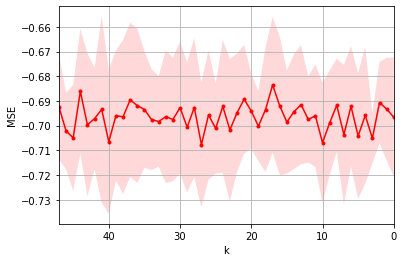

In [25]:
MSE_arr = -GSCV.cv_results_['mean_test_score']
std_arr = GSCV.cv_results_['std_test_score']
plt.plot(k_arr, MSE_arr, 'r.-')
plt.fill_between(k_arr, MSE_arr - std_arr, MSE_arr + std_arr, alpha=0.15, facecolor='red')
plt.xlim([max(k_arr), 0])
plt.grid()
plt.xlabel('k')
plt.ylabel('MSE')
pass

Теперь обучим модель с данными параметрами.

accuracy =  0.716
f1 =  0.7190428349630281


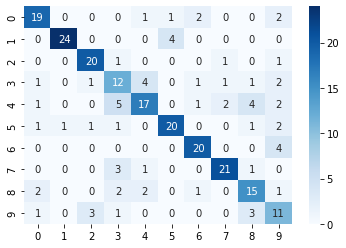

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        25
           1       0.96      0.86      0.91        28
           2       0.80      0.87      0.83        23
           3       0.48      0.52      0.50        23
           4       0.68      0.53      0.60        32
           5       0.80      0.74      0.77        27
           6       0.80      0.83      0.82        24
           7       0.84      0.81      0.82        26
           8       0.60      0.65      0.63        23
           9       0.44      0.58      0.50        19

    accuracy                           0.72       250
   macro avg       0.72      0.72      0.71       250
weighted avg       0.73      0.72      0.72       250



In [12]:
rfc_model = RandomForestClassifier(criterion = 'gini', max_depth = 30, n_estimators = 700)
rfc_model.fit(x_train, y_train)

rfc_prediction = rfc_model.predict(x_test)
print('accuracy = ', accuracy_score(rfc_prediction, y_test))
print('f1 = ', f1_score(rfc_prediction, y_test, average='weighted'))

ax = sns.heatmap(confusion_matrix(rfc_prediction, y_test), annot=True, cmap='Blues')
plt.show()

print(classification_report(rfc_prediction, y_test))

Метод подбора параметров хоть и работает не очень быстро, но, при этом, экономит достаточно времени по сравнению с ручным перебором тех же параметров, чем дает явное преимущество в использовании при построении моделей.

## Вывод

Была поставлена задача классификации жанра музыкальной композиции. 

Данны были получены из датасета Audio Data - GTZAN. Данные были предобработаны, проверено, что нет пропущеенных значений, быди исключены нерелевантные признаки, обработаны категориальные признаки. 

Данные были масштабированы и разделены на обучающую и тестовую выборки для дальнейшего обучения. Обучающая выборка была визуализирована.

Далее, были обучены 4 метода классификации: Метод k-ближайших соседей, Метод опорных векторов, Случайный лес, Логистическая регрессия.

Лучшие значения метрик у методов следующие:

Метод k-ближайших соседей (K-Nearest Neighbors) при k = 5: accuracy =  0.808, f1 =  0.8075495995928977

Метод опорных векторов (Support Vector Machines) при kernel='rbf' accuracy =  0.736, f1 =  0.7368163490290761

Случайный лес (Random Forests) при n_estimators=250, max_depth=25, criterion="entropy" accuracy =  0.724, f1 =  0.728220222071988

Логистическая регрессия (Logistic Regression) при solver='saga' accuracy =  0.732, f1 =  0.7313713566574901, но solver='sag' по метрикам почтисовпадает.

Для метода Случайный лес был проведен подбор гиперпаратеров и отображен график зависимости ошибки от параметров.

Можно увидеть, что наибольшее значение метрик у метода k-ближайших соседей. 